### Encoding networks

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [75]:
import os

import matplotlib
import numpy as np
import xarray as xr
from mne.viz import plot_connectivity_circle

from GDa.util import _create_roi_area_mapping

In [3]:
root = "/home/vinicius/funcog/gda/Results/lucy/mutual_information/"

#### Load power t-values

In [4]:
t_power = xr.load_dataarray(
    os.path.join(root, "tval_pow_1_br_1_aligned_cue_avg_1_fdr.nc")
)
p_power = xr.load_dataarray(
    os.path.join(root, "pval_pow_1_br_1_aligned_cue_avg_1_fdr.nc")
)

In [5]:
t_power = t_power * (p_power < 0.01)

#### Load coherence t-values

In [6]:
t_coh = xr.load_dataarray(os.path.join(root, "t_coh_avg_1_thr_1_fdr.nc"))
p_coh = xr.load_dataarray(os.path.join(root, "pval_coh_avg_1_thr_1_fdr.nc"))

In [7]:
t_coh = t_coh * (p_coh < 0.01)

In [13]:
freqs = t_coh.freqs.data
times = t_coh.times.data

In [8]:
roi_s, roi_t, roi_is, roi_it, areas, mapping = _create_roi_area_mapping(t_coh.roi.data)

#### Create matrix with entries for net plot

In [50]:
t_coh_mat = np.zeros(
    (t_coh.sizes["freqs"], t_coh.sizes["times"], len(areas), len(areas))
)

In [51]:
for p, (s, t) in enumerate(zip(roi_s, roi_t)):
    i_s, i_t = mapping[s], mapping[t]
    t_coh_mat[..., i_s, i_t] = t_coh_mat[..., i_t, i_s] = t_coh[..., p]

In [52]:
t_coh_mat = xr.DataArray(
    con,
    dims=("freqs", "times", "sources", "targets"),
    coords=(freqs, times, areas, areas),
)

#### Create plot

In [82]:
vmin = 0
vmax = 20

freq, time = 3, 0

# Matrix for the specific space-time
con = t_coh_mat.sel(freqs=freq, times=freq).data
# Powers for the specific space-time
powers = t_power.sel(freqs=freq, times=time)
# Create array with node sizes
node_sizes = []
for roi in areas:
    if roi in powers.roi.data:
        node_sizes += [powers.sel(roi=roi).data]
    else:
        node_sizes += [0]
node_sizes = np.asarray(node_sizes)

In [83]:
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
# Get colormap
cmap = matplotlib.cm.get_cmap("hot_r")
colors = [cmap(norm(val)) for val in node_sizes]

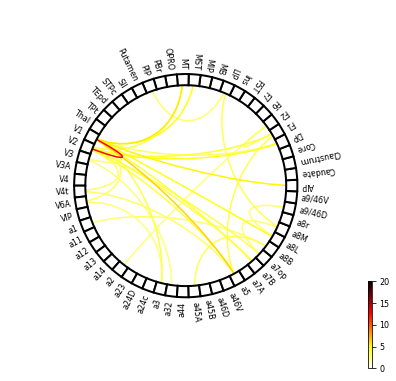

(<Figure size 576x576 with 2 Axes>, <PolarAxesSubplot:>)

In [84]:
plot_connectivity_circle(
    con,
    t_coh_mat.sources.data,
    colormap="hot_r",
    facecolor="white",
    textcolor="black",
    vmin=0,
    vmax=vmax,
    node_colors=colors,
    n_lines=30,
)